In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
#ANNALYSE DE DONNEES AVEC PYTHON
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import scipy.stats as st

#SERIE TEMPORELLE AVEC statsmodels
from   statsmodels.tsa.seasonal import seasonal_decompose
from   statsmodels.tsa.stattools import acf, pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from   statsmodels.tsa.statespace.sarimax import *

from pandas.tseries.offsets import MonthEnd

#CALCUL DE METRICS OU PRECISON DU MODEL
from sklearn.metrics import mean_absolute_error, mean_squared_error

#GESTION DES AVERTISSEMENTS
import warnings
warnings.filterwarnings('ignore')

C:\Users\sambe\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\sambe\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Base de donnees


Vous téléchargerez les données mensuelles de consommation totale d'électricité en énergie à partir de cette page:

https://www.rte-france.com/eco2mix/telecharger-les-indicateurs

Les données météo que vous utiliserez pour corriger les données de l'effet température sont présentes ici : 

https://cegibat.grdf.fr/simulateur/calcul-dju

In [3]:
data0 = pd.read_csv("energie.csv", sep = ';')
data=data0.query('Territoire=="France"')
data

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,2021-07,Données consolidées,France,40555,28449.0,1605,54.0,159,1392,5626,...,892,32959,7268.0,9252.0,2080.0,1907.0,1316.0,2090.0,1353.0,NaN
1357,2021-08,Données consolidées,France,39162,29010.0,957,70.0,166,720,4408,...,857,31184,7600.0,9266.0,1698.0,1878.0,1837.0,2090.0,1393.0,NaN
1370,2021-09,Données consolidées,France,38505,29001.0,2197,498.0,146,1552,3417,...,815,32350,5764.0,2118.0,6126.0,1114.0,1433.0,2126.0,1468.0,NaN
1383,2021-10,Données consolidées,France,41695,30658.0,3621,600.0,180,2840,3092,...,812,36762,4291.0,2745.0,4155.0,464.0,861.0,2141.0,1873.0,NaN


In [4]:
data.index=data.Mois

<Axes: xlabel='Mois'>

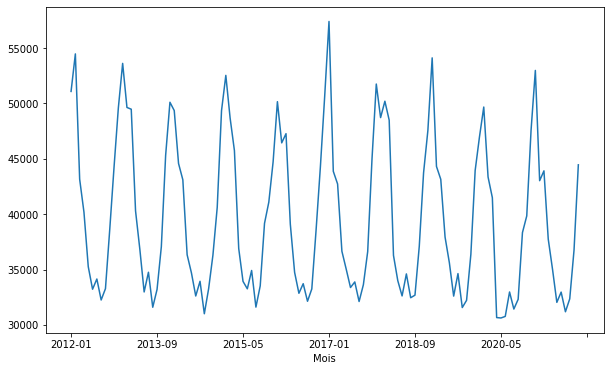

In [5]:
y=data["Consommation totale"]
y.plot(figsize=(10,6))

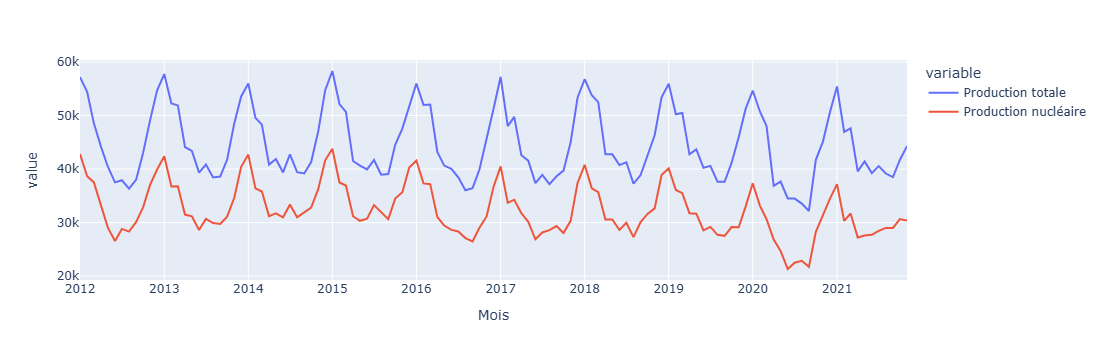

In [50]:
import plotly.express as px
data3=data[["Production totale","Production nucléaire"]]
fig = px.line(data3, facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

In [51]:
data[["Production totale","Production nucléaire"]].corr()

,Production totale,Production nucléaire
Production totale,1.000000,0.932793
Production nucléaire,0.932793,1.000000


## Modele Sarima

### Choix des parametres optimaux

C'est une méthode qui recherche de façon exhaustive la meilleure combinaison des paramètres du modele SARIMAX avec les donnees d entree sur la consommation

In [7]:
#comment choisir les meilleurs parametres (p,d,q)(P,D,Q)(s) pour le modele

import pmdarima   #(p,d,q)  #(P,D,Q, s)  
pmdarima.arima.auto_arima(y,                          
                          start_p=0, max_p=12, #chercher le meilleur parametre p entre 0 et 12
                          start_q=0, max_q=12,
                          start_d=0, max_d=12,  
                          start_P=0, max_P=12,
                          start_Q=0, max_Q=12,
                          start_D=0, max_D=12,  
                          m=12)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [8]:
#cette recherche exhaustive me conseille de choisir que la consommation du dernier mois (p=1) et celles des deux dernieres annees (P=2)

In [9]:
#le meilleur modele en terme de precision pourrait etre le modele SARIMA avec les paremetres:
#(p,d,q)(P,D,Q)(s)=(1,0,0)(2,0,0)[12]

### Entrainer le modele

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX   

#choix des parametres du modele
p,d,q=1,0,0   # TENDANCE: on prends la conso du mois dernier( p=1)
P,D,Q=2,0,0   # SAISONNALITE: on prends la conso des deux dernieres saisons (P=2)
s=12
#on instancie le modele SARIMA

model = SARIMAX(y, order=(p,d,q), seasonal_order = (P,Q,D, s))
#on entraine le modele
results = model.fit()
#les resultats fournis par le modele
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Consommation totale   No. Observations:                  119
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1118.936
Date:                            Fri, 14 Mar 2025   AIC                           2245.872
Time:                                    13:59:33   BIC                           2256.989
Sample:                                01-01-2012   HQIC                          2250.386
                                     - 11-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4981      0.063      7.888      0.000       0.374       0.622
ar.S.L12       0.3414      0.053      6.428      0.000       0.237       0.445
ar.S.L24       0.6549      0.053     12.341      0.000       0.551       0.759
sigma2      5.204e+06   2.82e-09   1.85e+15      0.000     5.2e+06     5.2e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.91   Jarque-Bera (JB):                13.69
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.37
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.07e+30. Standard errors may be unstable.
"""

### Formulation interpretabilité

### Validation du modele

In [11]:
#regardons si les erreurs sont normales
st.shapiro(results.resid)[1]

3.5688298570505533e-16

In [12]:
#pvalue<5% donc les erreurs du modele ne sont pas normales
#conclusion: il ne faut pas valider le modele à ce stade, il faut l'ameliorer!

#IDEES:  1. recolter plus de données (MORE DATA)
        #2. Changer de modele (en general choisir un plus plus compliqué: machine learning, deep learning, transformeur)
        #3. Optimiser d'avantage les parametres du modele (Grid Search CV)
        #4. Aller cherches les autres variables eXXXXXXogenes autres que le temps, la saisonnalité, bruit


### Precision du modele

In [13]:
predictions=results.forecast(steps=119,start_index = "2012-01-31")

In [14]:
resultats=pd.DataFrame()
resultats["reel"]=data["Consommation totale"].values   #je stocke la realité
resultats["pred"]=predictions.round(0).values   #je stocke la prediction
resultats["erreur relative"]=abs((resultats["pred"]-resultats["reel"])/resultats["reel"]*100)

resultats.sample(20)


,reel,pred,erreur relative
66,33877,31128.0,8.114650
58,44293,37004.0,16.456325
115,31184,32204.0,3.270908
47,44727,42554.0,4.858363
101,30763,32550.0,5.808926
69,36615,31874.0,12.948245
5,33219,32036.0,3.561215
71,51754,42167.0,18.524172
59,50670,41885.0,17.337675
110,43913,42303.0,3.666340


In [15]:
resultats.describe()

,reel,pred,erreur relative
count,119.000000,119.000000,119.000000
mean,39613.798319,37992.277311,8.704975
std,7050.614648,6690.632099,6.307358
min,30622.000000,30556.000000,0.084195
25%,33267.500000,32191.000000,3.368527
50%,37063.000000,35995.000000,7.785159
75%,44653.500000,42581.000000,13.166186
max,57406.000000,52154.000000,37.337726


In [16]:

mae = mean_absolute_error(resultats["reel"], resultats["pred"])
mse = mean_squared_error(resultats["reel"], resultats["pred"])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((resultats["reel"]-resultats["pred"]) / resultats["pred"])) * 100

print('MAE = ', mae)  #on comments des erreurs absolues de l ordre de 3589 sur les predictions
print('RMSE = ', rmse) ##on comments des erreurs quadratiques de l ordre de 1769 sur les predictions
print('MAPE = ', mape)   #On commets des erreurs relatives de 9%    (modele validé avec une precision de 91%)

MAE =  3589.285714285714
RMSE =  4502.256981156201
MAPE =  9.260486164877427


In [17]:
#Le modele comment des erreurs de l'ordre de 9.11%, cependant il ne faut pas le valider car les erreurs generées restent anormales

### Modele general

In [18]:

target = data["Consommation totale"]
target.head()

Mois
2012-01    51086
2012-02    54476
2012-03    43156
2012-04    40176
2012-05    35257
Name: Consommation totale, dtype: int64

In [19]:
data.columns

Index(['Mois', 'Qualité', 'Territoire', 'Production totale',
       'Production nucléaire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production éolien', 'Production solaire', 'Production bioénergies',
       'Consommation totale', 'Solde exportateur', 'Echanges export',
       'Echanges import', 'Echanges avec le Royaume-Uni',
       'Echanges avec l'Espagne', 'Echanges avec l'Italie',
       'Echanges avec la Suisse', 'Echanges avec l'Allemagne et la Belgique'],
      dtype='object')

In [20]:
 #variables EXOGENES (explicatives)
#on prend que les variables qui causent la conso et qui ne creeraient pas d'instabilité à long terme (c'est à dire qui ne "data driftent pas")
exog=data[['Production totale', #ok
           'Production thermique totale', #ok
           'Solde exportateur',  #ok
           'Echanges export',  #ok
           'Echanges import']].fillna(0)

exog = data[["Production totale","Production nucléaire","Production thermique totale","Production thermique charbon"]]

In [21]:
n=20 #on cache aux modeles les 20 derniers mois
#on prends les 119-20 premieres donnees pour le train et 33 pour le test (vous pouvez aussi modifier cette repartition)
train= target.head(119-n)
test=target.tail(n)

In [22]:
#plus simple
exog_train= exog.head(119-n) #les 100 premiers pour entrainer le modele
exog_test=exog.tail(n)     #les 19 derniers pour tester le modele 


In [23]:
p=1;P=2
d=0;D=0
q=0;Q=0
s=12

# define model configuration
my_order = (p, d, q)
my_seasonal_order = (P, D, Q, s) 


# define model configuration
#my_order = (24, 0, 0) #pqd: appliquée à la seried e depart
#my_seasonal_order = (0, 0, 0, 12) #PQD et S=saison (tres souvent c'est 12) appliquée à la SAISONNALITE



# define model
model5 = SARIMAX(train, #les donnees d entrainement
                 exog=exog_train, #on prend en compte les variables eXogenes (productions)
                 order=my_order,  #les hyperparametres (p,d,q)
                 seasonal_order=my_seasonal_order)  ##les hyperparametres (P,D,Q,s)

results5 = model5.fit()
results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Consommation totale   No. Observations:                   99
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -822.560
Date:                            Fri, 14 Mar 2025   AIC                           1661.121
Time:                                    13:59:37   BIC                           1681.882
Sample:                                01-01-2012   HQIC                          1669.521
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Production totale                0.8651      0.084     10.276      0.000       0.700       1.030
Production nucléaire            -0.1011      0.110     -0.918      0.359      -0.317       0.115
Production thermique totale      1.1046      0.126      8.764      0.000       0.858       1.352
Production thermique charbon     0.6259      0.363      1.723      0.085      -0.086       1.338
ar.L1                            0.3238      0.098      3.301      0.001       0.132       0.516
ar.S.L12                         0.1125      0.115      0.974      0.330      -0.114       0.339
ar.S.L24                         0.1235      0.130      0.952      0.341      -0.131       0.378
sigma2                        9.969e+05   5.49e-08   1.81e+13      0.000    9.97e+05    9.97e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.82   Prob(JB):                         0.67
Heteroskedasticity (H):               1.53   Skew:                            -0.11
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.24e+29. Standard errors may be unstable.
"""

<Axes: ylabel='Density'>

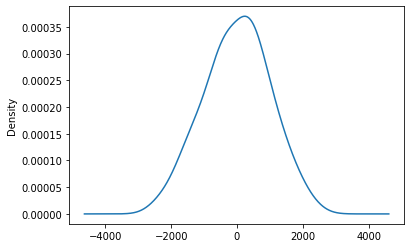

In [24]:
results5.resid.plot(kind="density")

In [25]:
st.shapiro(results5.resid)
#pvalue>5% donc on ne peut pas rejeter l'hypothese de normalité des residus
#conslusion sur la base des statistiques: ON VALIDE LE MODELE

ShapiroResult(statistic=0.993486225605011, pvalue=0.9183127284049988)

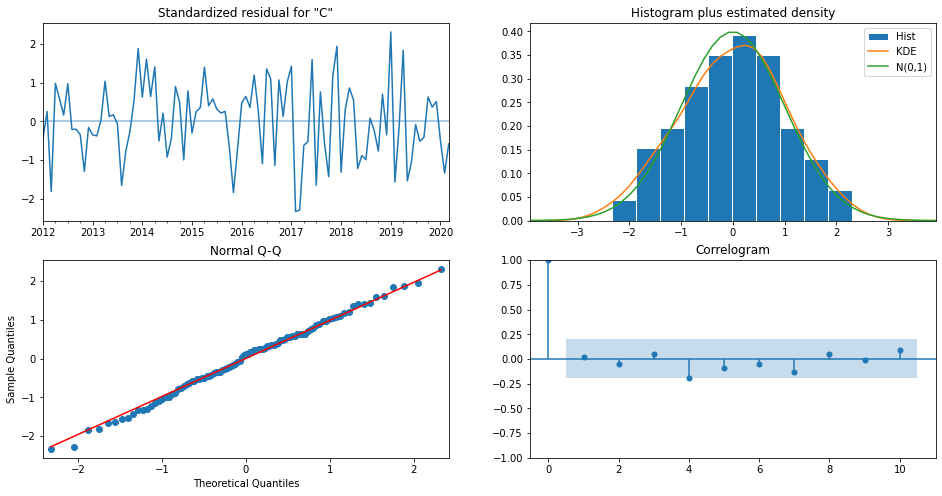

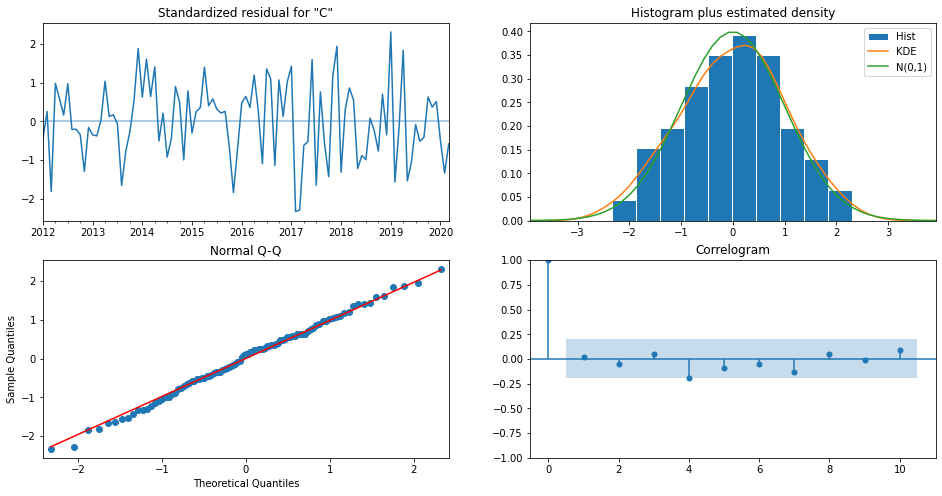

In [26]:
results5.plot_diagnostics(figsize=(16,8))

In [27]:
predictions=results5.forecast(steps=119,start_index = "2012-01-31", exog = exog)
predictions

2020-04-01    51530.392927
2020-05-01    54017.383375
2020-06-01    44635.498654
2020-07-01    39498.688936
2020-08-01    34440.802365
                  ...     
2029-10-01    34014.472706
2029-11-01    32046.904536
2029-12-01    33117.077038
2030-01-01    37346.037370
2030-02-01    41918.737034
Freq: MS, Name: predicted_mean, Length: 119, dtype: float64

In [28]:
yhatsarimax=predictions

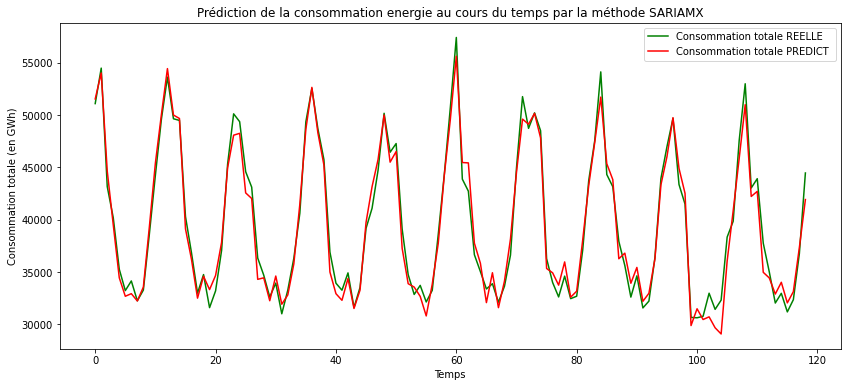

In [29]:
predictions=results5.forecast(steps=119,start_index = "2012-01-31", exog = exog)
predictions
plt.figure(figsize=(14,6))
plt.plot(target.values, label='Consommation totale REELLE', color='green')

plt.plot(predictions.values, label='Consommation totale PREDICT ', color='red')

plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation energie au cours du temps par la méthode SARIAMX')
plt.legend(loc='best')
plt.show()

In [30]:
st.shapiro(results5.resid)[1]

0.9183127284049988

In [31]:
#pvalue>5%, on accepte la normalité. donc modele validé statistiquement!!!


In [32]:
y_pred5=predictions.values[-n:]
y_pred5

array([29879.39925692, 31482.32154175, 30455.98490659, 30711.47081529,
       29667.05994718, 29074.93589044, 36045.44895686, 40834.22643403,
       45850.81450542, 50984.53338775, 42215.93407844, 42700.73575017,
       34965.69065999, 34427.9398371 , 32889.63915094, 34014.47270647,
       32046.90453614, 33117.07703778, 37346.03736966, 41918.73703361])

In [33]:
y_true5=target.values[-n:]
y_true5

array([30658, 30622, 30763, 32970, 31428, 32307, 38332, 39840, 47565,
       52983, 43024, 43913, 37747, 35007, 32032, 32959, 31184, 32350,
       36762, 44458], dtype=int64)

In [34]:
predictions=results5.forecast(steps=119,start_index = "2012-01-31", exog = exog)

mae = mean_absolute_error(y_true5, y_pred5)
mse = mean_squared_error(y_true5, y_pred5)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true5 - y_pred5) / y_pred5)) * 100

print('MAE = ', mae)  #on comments des erreurs absolues de l ordre de 1514 sur les predictions
print('MSE = ', mse)  #pas interessant à cause de l'echelle
print('RMSE = ', rmse) ##on comments des erreurs quadratiques de l ordre de 1769 sur les predictions
print('MAPE = ', mape)   #On commets des erreurs relatives de 0.59%    (modele validé avec une precision de 99.5%)

MAE =  1411.8996875499442
MSE =  2670145.898628435
RMSE =  1634.0581074822385
MAPE =  3.9959847594083846


In [35]:
predictions=results5.get_forecast(steps=119,start_index = "2012-01-31", exog = exog).summary_frame()
predictions.index=exog.index
predictions["reel"]=y
predictions

Consommation totale,mean,mean_se,mean_ci_lower,mean_ci_upper,reel
Mois,,,,,
2012-01,51530.392927,998.444952,49573.476782,53487.309073,51086
2012-02,54017.383375,1049.489983,51960.420806,56074.345943,54476
2012-03,44635.498654,1054.699604,42568.325416,46702.671892,43156
2012-04,39498.688936,1055.244409,37430.447898,41566.929973,40176
2012-05,34440.802365,1055.301523,32372.449388,36509.155343,35257
...,...,...,...,...,...
2021-07,34014.472706,1072.321174,31912.761826,36116.183587,32959
2021-08,32046.904536,1072.321174,29945.193655,34148.615417,31184
2021-09,33117.077038,1072.321174,31015.366157,35218.787919,32350


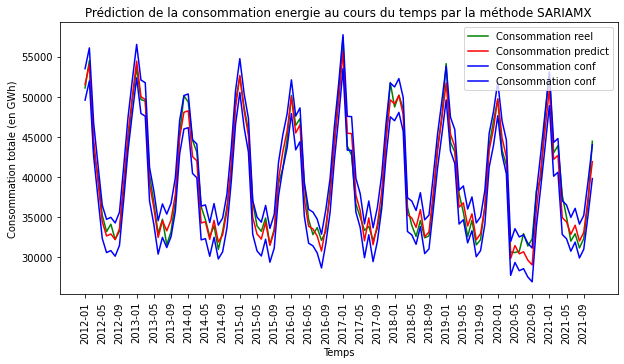

In [36]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(predictions[['reel']], label='Consommation reel', color='green')
plt.plot(predictions[['mean']], label='Consommation predict', color='red')

plt.plot(predictions[['mean_ci_lower', 'mean_ci_upper']], label='Consommation conf', color='blue')
#plt.vlines(x = 100, ymin =target.min()*1.2, ymax = 0.8*target.max(), colors = 'blue',linestyles = "solid",linewidth=10)
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation energie au cours du temps par la méthode SARIAMX')
plt.legend(loc='best')
plt.xticks(rotation=90)
# Sélectionner les index des dates à afficher tous les 4 points
plt.xticks(ticks=predictions.index[::4], labels=predictions.index[::4], rotation=90)

# Ajouter la légende
plt.legend(loc='best')

# Afficher le graphique
plt.show()

## Modele en production

In [42]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définition des données exogènes et de la cible
exog = data[["Production totale", "Production nucléaire", "Production thermique totale", "Production thermique charbon"]]
target = data["Consommation totale"]

n = 12  # Nombre d'observations pour le test

# Séparer les données en train et test
train = target.head(119 - n)
test = target.tail(n)

exog_train = exog.head(119 - n)
exog_test = exog.tail(n)

# Paramètres du modèle SARIMAX
p, d, q = 24, 0, 0  # Ordre du modèle
P, D, Q, s = 0, 0, 0, 12  # Ordre saisonnier

# Dictionnaire pour stocker les modèles et prédictions des variables exogènes
predicted_exog = {}

# Boucle pour entraîner un modèle univarié SARIMAX sur chaque variable exogène
for var in exog.columns:
    print(f"Training SARIMAX for {var}...")
    
    # Définir et entraîner le modèle SARIMAX sur la variable exogène
    model_exog = SARIMAX(exog_train[var], 
                         order=(p, d, q), 
                         seasonal_order=(P, D, Q, s))
                         #exog=None)
    
    results_exog = model_exog.fit()
    
    # Prédire la variable exogène
    predicted_exog[var] = results_exog.forecast(steps=n)

# Convertir les prédictions en DataFrame
predicted_exog_df = pd.DataFrame(predicted_exog, index=exog_test.index)

# Définition du modèle SARIMAX pour la consommation avec les prédictions des variables exogènes
model5 = SARIMAX(train,
                 exog=exog_train,  # Entraînement avec les données historiques
                 order=(p, d, q),
                 seasonal_order=(P, D, Q, s))

# Entraînement du modèle
results5 = model5.fit()

# Prédiction de la consommation en utilisant les prédictions des variables exogènes
predictions = results5.forecast(steps=n, exog=predicted_exog_df)

# Affichage des résultats
predictions


Training SARIMAX for Production totale...
Training SARIMAX for Production nucléaire...
Training SARIMAX for Production thermique totale...
Training SARIMAX for Production thermique charbon...


2020-12-01    48056.947766
2021-01-01    48108.323737
2021-02-01    43178.362408
2021-03-01    42112.735745
2021-04-01    34302.510851
2021-05-01    33960.592717
2021-06-01    31485.583371
2021-07-01    31942.628854
2021-08-01    33005.764190
2021-09-01    30488.196387
2021-10-01    36960.152540
2021-11-01    40138.590648
Freq: MS, Name: predicted_mean, dtype: float64

In [43]:
result=pd.DataFrame()
result.index=exog_test.index
result["reel"]=test
result["pred"]=predictions
result

,reel,pred
Mois,,
2020-12,47565,48056.947766
2021-01,52983,48108.323737
2021-02,43024,43178.362408
2021-03,43913,42112.735745
2021-04,37747,34302.510851
2021-05,35007,33960.592717
2021-06,32032,31485.583371
2021-07,32959,31942.628854
2021-08,31184,33005.764190


In [44]:
result["erreur"]=(result["pred"]-result["reel"])/result["pred"]*100
result

,reel,pred,erreur
Mois,,,
2020-12,47565,48056.947766,1.023677
2021-01,52983,48108.323737,-10.132709
2021-02,43024,43178.362408,0.357499
2021-03,43913,42112.735745,-4.274869
2021-04,37747,34302.510851,-10.041507
2021-05,35007,33960.592717,-3.081240
2021-06,32032,31485.583371,-1.735450
2021-07,32959,31942.628854,-3.181864
2021-08,31184,33005.764190,5.519533


In [46]:
result.erreur.abs().describe()

count    12.000000
mean      4.729362
std       3.826100
min       0.357499
25%       1.557507
50%       3.728367
75%       7.090355
max      10.761238
Name: erreur, dtype: float64

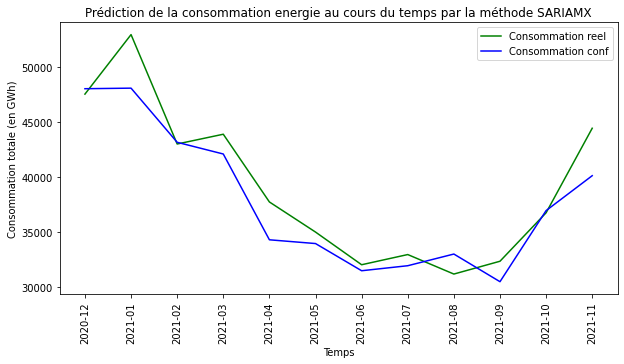

In [47]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(test, label='Consommation reel', color='green')

plt.plot(predictions.values, label='Consommation conf', color='blue')

plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation energie au cours du temps par la méthode SARIAMX')
plt.legend(loc='best')
plt.xticks(rotation=90)
# Sélectionner les index des dates à afficher tous les 4 points
#plt.xticks(ticks=predictions.index[::4], labels=predictions.index[::4], rotation=90)

# Ajouter la légende
plt.legend(loc='best')

# Afficher le graphique
plt.show()

In [49]:
erreur=(predicted_exog_df-exog_test)/exog_test*100
erreur.abs().mean()

Production totale                4.590488
Production nucléaire             6.238557
Production thermique totale     35.704388
Production thermique charbon    98.505199
dtype: float64

In [ ]:
#Les modeles avec prod thermique et charbon ne sont pas precis donc on ne va pas utiliser ces 2 variables exogenes (cours: X1 est une bonne variable explicative si:
                               # elle cause Y, elle datadrifte pas, elle est previsible)

### prediction pour d autres dates

In [52]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définition des données exogènes et de la cible
exog = data[["Production totale", "Production nucléaire"]]
target = data["Consommation totale"]

n = 12  # Nombre d'observations pour le test

# Séparer les données en train et test
train = target.head(119 - n)
test = target.tail(n)

exog_train = exog.head(119 - n)
exog_test = exog.tail(n)

# Paramètres du modèle SARIMAX
p, d, q = 24, 0, 0  # Ordre du modèle
P, D, Q, s = 0, 0, 0, 12  # Ordre saisonnier
NBMOIS=24 # pour faire des predictions sur les 24 prochains MOIS
# Dictionnaire pour stocker les modèles et prédictions des variables exogènes
predicted_exog = {}

# Boucle pour entraîner un modèle univarié SARIMAX sur chaque variable exogène
for var in exog.columns:
    print(f"Training SARIMAX for {var}...")
    
    # Définir et entraîner le modèle SARIMAX sur la variable exogène
    model_exog = SARIMAX(exog_train[var], 
                         order=(p, d, q), 
                         seasonal_order=(P, D, Q, s))
                         #exog=None)
    
    results_exog = model_exog.fit()
    
    # Prédire la variable exogène
    predicted_exog[var] = results_exog.forecast(steps=n+NBMOIS)  #APPLIVCATION

# Convertir les prédictions en DataFrame
predicted_exog_df = pd.DataFrame(predicted_exog)

# Définition du modèle SARIMAX pour la consommation avec les prédictions des variables exogènes
model5 = SARIMAX(train,
                 exog=exog_train,  # Entraînement avec les données historiques
                 order=(p, d, q),
                 seasonal_order=(P, D, Q, s))

# Entraînement du modèle
results5 = model5.fit()

# Prédiction de la consommation en utilisant les prédictions des variables exogènes
predictions = results5.forecast(steps=n+NBMOIS, exog=predicted_exog_df)

# Affichage des résultats
predictions


Training SARIMAX for Production totale...
Training SARIMAX for Production nucléaire...


2020-12-01    48472.281963
2021-01-01    48096.633049
2021-02-01    43977.058629
2021-03-01    41642.860456
2021-04-01    33178.133382
2021-05-01    34935.903053
2021-06-01    33301.830496
2021-07-01    31723.914156
2021-08-01    34332.746283
2021-09-01    31875.567571
2021-10-01    38795.786520
2021-11-01    40622.565942
2021-12-01    48487.198696
2022-01-01    47855.626228
2022-02-01    43544.031727
2022-03-01    40701.777501
2022-04-01    33916.742744
2022-05-01    34773.616943
2022-06-01    32769.003652
2022-07-01    31281.968952
2022-08-01    33967.171274
2022-09-01    30863.321935
2022-10-01    38728.883615
2022-11-01    39960.712323
2022-12-01    47465.750265
2023-01-01    48436.973212
2023-02-01    44042.292354
2023-03-01    41916.035785
2023-04-01    34677.694822
2023-05-01    34776.077786
2023-06-01    34580.443373
2023-07-01    32509.944854
2023-08-01    34655.493397
2023-09-01    31263.310085
2023-10-01    38896.235309
2023-11-01    40535.286123
Freq: MS, Name: predicted_me

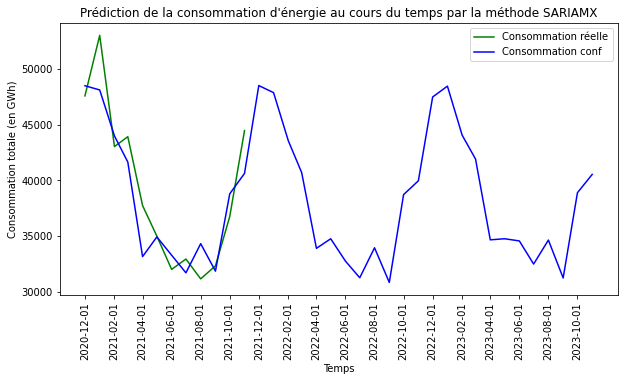

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (10,5)

# Vérifier si l'index des prédictions est de type datetime, sinon le convertir
if not isinstance(predictions.index, pd.DatetimeIndex):
    predictions.index = pd.to_datetime(predictions.index)

# Vérifier également pour test (éviter d'éventuels conflits)
if not isinstance(test.index, pd.DatetimeIndex):
    test.index = pd.to_datetime(test.index)

# Tracer les séries temporelles
plt.plot(test.index, test.values, label='Consommation réelle', color='green')
plt.plot(predictions.index, predictions.values, label='Consommation conf', color='blue')

# Ajouter des titres et légendes
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode SARIAMX')
plt.legend(loc='best')

# Mettre les dates des prédictions sur l'axe X en s'assurant qu'elles sont sous un format valide
plt.xticks(ticks=predictions.index[::2], labels=predictions.index[::2].strftime('%Y-%m-%d'), rotation=90)

# Afficher le graphique
plt.show()


In [54]:
predictions

2020-12-01    48472.281963
2021-01-01    48096.633049
2021-02-01    43977.058629
2021-03-01    41642.860456
2021-04-01    33178.133382
2021-05-01    34935.903053
2021-06-01    33301.830496
2021-07-01    31723.914156
2021-08-01    34332.746283
2021-09-01    31875.567571
2021-10-01    38795.786520
2021-11-01    40622.565942
2021-12-01    48487.198696
2022-01-01    47855.626228
2022-02-01    43544.031727
2022-03-01    40701.777501
2022-04-01    33916.742744
2022-05-01    34773.616943
2022-06-01    32769.003652
2022-07-01    31281.968952
2022-08-01    33967.171274
2022-09-01    30863.321935
2022-10-01    38728.883615
2022-11-01    39960.712323
2022-12-01    47465.750265
2023-01-01    48436.973212
2023-02-01    44042.292354
2023-03-01    41916.035785
2023-04-01    34677.694822
2023-05-01    34776.077786
2023-06-01    34580.443373
2023-07-01    32509.944854
2023-08-01    34655.493397
2023-09-01    31263.310085
2023-10-01    38896.235309
2023-11-01    40535.286123
Freq: MS, Name: predicted_me

In [58]:
data["annee"]=data["Mois"].str[0:4]
data

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,annee
Mois,,,,,,,,,,,,,,,,,,,,,
2012-01,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0,2012
2012-02,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0,2012
2012-03,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0,2012
2012-04,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0,2012
2012-05,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07,2021-07,Données consolidées,France,40555,28449.0,1605,54.0,159,1392,5626,...,32959,7268.0,9252.0,2080.0,1907.0,1316.0,2090.0,1353.0,NaN,2021
2021-08,2021-08,Données consolidées,France,39162,29010.0,957,70.0,166,720,4408,...,31184,7600.0,9266.0,1698.0,1878.0,1837.0,2090.0,1393.0,NaN,2021
2021-09,2021-09,Données consolidées,France,38505,29001.0,2197,498.0,146,1552,3417,...,32350,5764.0,2118.0,6126.0,1114.0,1433.0,2126.0,1468.0,NaN,2021


<Axes: xlabel='annee'>

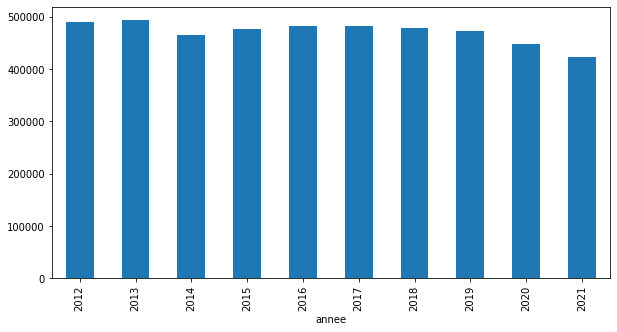

In [62]:
data.groupby("annee").sum()["Consommation totale"].plot(kind="bar")